##GENERATE RANDOM ANOMALY DATASET

In [ ]:
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset
from collections import defaultdict
from torchvision import transforms
import random
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Random_Anomaly_Github'   #set to data directory
filepath = data_dir+'/RandomAnomaly_Train_'                         #will be used as stem for file names
min_copies = 10                                                     #minimum copies in a sequence
max_copies = 10                                                     #maximum copies in a sequence, often set to match minimum
transform = None                                                    #can be used to specify a specific base transform, default is None for random variation
anomaly_transform = None                                            #can be used to specify a specific anomaly transform, default is None for random variation
anomaly_prob = 1                                                    #can be used to specify probability 0-1 of anomaly in a given sequence, default is 1 (every sequence has an anomaly)

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

def get_transform(name):

    if name == 'baseline':
        transform = transforms.Compose([
            transforms.Resize((50, 50)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    elif name == 'perspective_small_anomaly':
        transform = transforms.Compose([
            transforms.Resize((50, 50)),
            transforms.RandomPerspective(p=1.0, fill=0, distortion_scale=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ])
    elif name == 'perspective_anomaly':
        transform = transforms.Compose([
            transforms.Resize((50, 50)),
            transforms.RandomPerspective(p=1.0, fill=0, distortion_scale=0.9),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ])
    elif name == 'erase_anomaly':
        transform = transforms.Compose([
            transforms.Resize((50, 50)),
            transforms.ToTensor(),
            transforms.RandomErasing(p=1.0, scale=(0.1,0.2)),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    elif name == 'noise_anomaly':
        transform = transforms.Compose([
            transforms.Resize((50, 50)),
            transforms.ToTensor(),
            AddGaussianNoise(std=0.01),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    elif name == 'both_anomaly':
        transform = transforms.Compose([
            transforms.Resize((50, 50)),
            transforms.ToTensor(),
            transforms.RandomErasing(p=1.0, scale=(0.1, 0.2)),
            transforms.ToPILImage(),
            transforms.RandomPerspective(p=1.0, fill=0, distortion_scale=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ])
    elif name == 'blur_anomaly':
        transform = transforms.Compose([
            transforms.Resize((50, 50)),
            transforms.ToTensor(),
            transforms.GaussianBlur(15),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    elif name == 'sharpness_anomaly':
        transform = transforms.Compose([
            transforms.Resize((50, 50)),
            transforms.ToTensor(),
            transforms.RandomAdjustSharpness(sharpness_factor=4, p=1.0),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    return transform

In [ ]:
class AnomalousRandom(Dataset):
    def __init__(self, images, min_copies=1, max_copies=1, transform=None, anomaly_transform=None, anomaly_prob=1):
        self.images = images
        self.min_copies = min_copies
        self.max_copies = max_copies
        self.transform = transform
        self.anomaly_transform = anomaly_transform
        self.anomaly_prob=anomaly_prob

        self.label_map = defaultdict(lambda: [])
        for idx,sample in enumerate(images):
            self.label_map[sample[1]] += [idx]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_sequence = []
        label_sequence = []

        available_transforms = ['baseline', 'perspective_small_anomaly', 'perspective_anomaly', 'erase_anomaly', 'noise_anomaly', 'both_anomaly', 'blur_anomaly', 'sharpness_anomaly']
        indices = torch.randperm(len(available_transforms))[:2].tolist()
        base_transform, alt_transform = available_transforms[indices[0]], available_transforms[indices[1]]
        if self.transform and self.anomaly_transform:
            base_transform = self.transform
            alt_transform = self.anomaly_transform
        elif self.transform:
            if alt_transform == self.transform: alt_transform = base_transform
            base_transform = self.transform
        elif self.anomaly_transform:
            if base_transform == self.anomaly_transform: base_transform = alt_transform
            alt_transform = self.anomaly_transform

        baseline = get_transform('baseline')
        base_transform = get_transform(base_transform)
        alt_transform = get_transform(alt_transform)

        base_label = self.images[idx][1]
        for i in range(random.randint(self.min_copies, self.max_copies)):
            idx_same_label = random.choice(self.label_map[base_label])
            image = self.images[idx_same_label][0]
            baseline_img = baseline(image)
            lower, upper = torch.min(baseline_img), torch.max(baseline_img)
            image = base_transform(image)
            image = torch.clamp(image, min=lower, max=upper)
            image_sequence += [image]
            label_sequence += [0]

        swap_idx = torch.randint(len(image_sequence),(1,)).item()
        anomaly_location = len(image_sequence)
        if torch.rand((1,)).item() < self.anomaly_prob:
            idx_same_label = random.choice(self.label_map[base_label])
            image = self.images[idx_same_label][0]
            baseline_img = baseline(image)
            lower, upper = torch.min(baseline_img), torch.max(baseline_img)
            image = alt_transform(image)
            image = torch.clamp(image, min=lower, max=upper)
            image_sequence[swap_idx] = image
            label_sequence[swap_idx] = 1
            anomaly_location = swap_idx

        label_sequence += [anomaly_location]
        image_sequence += [image_sequence[0]*0.0]

        return {'x': image_sequence, 'y':label_sequence}

In [ ]:
def get_data_loader(data_dir, min_copies, max_copies, transform, anomaly_transform, anomaly_prob):
    MNISTdataset = datasets.MNIST(data_dir, download=True, transform=transform)

    AnomalyDataset = AnomalousRandom(MNISTdataset,
                                min_copies=min_copies,
                                max_copies=max_copies,
                                transform=transform,
                                anomaly_transform=anomaly_transform,
                                anomaly_prob=anomaly_prob)

    AnomalyDataloader = torch.utils.data.DataLoader(AnomalyDataset, num_workers=0, batch_size=None)
    return AnomalyDataloader

In [ ]:
AnomalyDataloader = get_data_loader(data_dir, min_copies, max_copies, transform, anomaly_transform, anomaly_prob)

100%|██████████| 9.91M/9.91M [00:00<00:00, 52.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 2.09MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 19.8MB/s]


In [ ]:
data = []

IterableLoader = iter(AnomalyDataloader)

size = len(IterableLoader)  #this can be hardcoded to another number less than the size of the loader, for example 10000

for r in range(1, size+1):

  series = next(IterableLoader)

  for i, s in enumerate(series['x']):
    series['x'][i] = s.squeeze(0).numpy().flatten()

  data.append(series)

  if r % 10000 == 0:
    print(r)
    data = pd.DataFrame(data)
    data.to_parquet(filepath+str(r//10000)+'.parquet.gzip', compression='gzip')
    data = []


1000
2000
3000
4000
5000
6000


##READ DATAFILE

In [ ]:
infile = pd.read_parquet(filepath+'1.parquet.gzip')

In [ ]:
#list of length number of samples
print(type(infile))
print(len(infile))
#each sample is structured as a list of length 2
print(type(infile.iloc[0]))
print(len(infile.iloc[0]))
#The first entry of each sample list is a list of 11 y values, binary integers for the 10 images and index integer of the anomaly for the blank 11th image
print(type(infile.iloc[0]['y']))
print(len(infile.iloc[0]['y']))
#The second entry of each sample list is the list of 11 x values
print(type(infile.iloc[0]['x']))
print(len(infile.iloc[0]['x']))
#Each x value is a list containing the 2500 dimensions of a 50x50 image
print(type(infile.iloc[0]['x'][0]))
print(len(infile.iloc[0]['x'][0]))

<class 'pandas.core.frame.DataFrame'>
1000
<class 'pandas.core.series.Series'>
2
<class 'numpy.ndarray'>
11
<class 'numpy.ndarray'>
11
<class 'numpy.ndarray'>
2500


In [ ]:
def make_image(images, labels, showlabels=False):
    num_row = 1
    num_col = len(labels)

    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(len(labels)):
        #ax = axes[i//num_col, i%num_col]
        ax = axes[i]
        #ax.imshow(images[i].squeeze(), cmap='gray')
        ax.imshow(np.array(images[i]).reshape((50,50)), cmap='gray')
        if showlabels:
            ax.set_title('Label: {}'.format(labels[i]))
            ax.set_title(labels[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

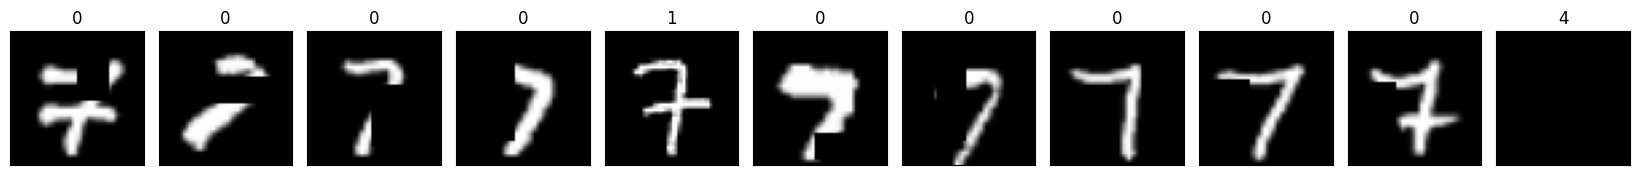

In [ ]:
image_idx = 15  #can be used to retrieve examples
make_image(infile.iloc[image_idx]['x'], infile.iloc[image_idx]['y'], showlabels=True)